In [2]:
import numpy as np
import xarray as xr

from eval_utilities import spatial_temporal_metrics as stm
from eval_utilities import visualization as vis
import matplotlib.pyplot as plt

/data/conda/envs/ailand/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [ ]:
import yaml
with open(f"config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
ds_ref = xr.open_zarr(CONFIG["path_ec_euro"]).sel(time=slice("2021-01-01T00", "2022-11-30T00"))
ds_mod = xr.open_zarr(CONFIG["path_xgb_diag_v2"]).sel(time=slice("2021-01-01T00", "2022-11-30T00"))

# Soil Moisture

## Field Capacity vs. Average Soil Moisture

In [ ]:
# Climate info:
field_cap = ds_ref.clim_data.sel(clim_variable="clim_theta_cap")
wilt_point = ds_ref.clim_data.sel(clim_variable="clim_theta_pwp")

# Average over time and soil moisture levels:
avg_ref = ds_ref.sel(variable=["swvl1","swvl2","swvl3"]).data.mean(dim=("time", "variable"))
avg_mod = ds_mod.sel(variable=["swvl1","swvl2","swvl3"]).data.mean(dim=("time", "variable"))


# Assemble data for boxplots:
fcaps = sorted(set(field_cap.values))
boxes_ref = []
boxes_mod = []
for fcap in fcaps:
    _ = avg_ref.where(ds_ref.clim_data.sel(clim_variable="clim_theta_cap") == fcap).values
    _ = _[~np.isnan(_)]
    boxes_ref.append(_)

    _ = avg_mod.where(ds_ref.clim_data.sel(clim_variable="clim_theta_cap") == fcap).values
    _ = _[~np.isnan(_)]
    boxes_mod.append(_)

In [ ]:
bpr = plt.boxplot(boxes_ref, positions=np.array(range(len(fcaps)))*2.0-0.4, widths=0.6)
bpm = plt.boxplot(boxes_mod, positions=np.array(range(len(fcaps)))*2.0+0.4, widths=0.6)
plt.xticks(range(0, len(fcaps) * 2, 2), fcaps)

# Distinguish mod and ref:
plt.setp(bpr['medians'], color="tab:orange", label="ref")
plt.setp(bpm['medians'], color="tab:blue", label="mod")

# Get rid of duplicates in the legend:
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("Field Capacity")
plt.ylabel("Average (time and vert) Soil Moisture")
plt.show()

## Sensitivity of Soil Moisture to Soil Properties

This first part is modified from "inference_xgboost.iypnb". It contains all necessary ingredients for running the inference.

In [ ]:
import xgboost as xgb
from tqdm import tqdm

from eval_utilities.EclandPointDataset import EcDataset

In [ ]:
data_path = "/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr"
model_path = "/home/ch23/weights_ch23/euro_xgb_train_2019_val_2020_all_variables.json"
spatial_encoding = False
temporal_encoding = False

# Dataset:
ds_inf = EcDataset(start_year = 2020, end_year = 2022, root = data_path, roll_out = 1, 
                   #clim_features=CONFIG["clim_feats"], dynamic_features=CONFIG["dynamic_feats"],
                   #target_prog_features=CONFIG["targets_prog"], target_diag_features=CONFIG["targets_diag"],
                   is_add_lat_lon = spatial_encoding, 
                   is_norm = True, 
                   point_dropout = 0.0)

# XGB Model:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="hist", device="cuda")
model.load_model(model_path)

Output should neither be stored nor is it necessary to predict the whole data set. Instead, we want to run the same grid point with different parameters.
Here, we are modifying only field capacitiy (for now). To get the whole range, field capacity is varied from $0$ to $0.75$ in steps of $0.05$.
The test sites are repeated and stacked to run the inference for all variations at once.

In [ ]:
# Choose test sites:
x_coords = [63699, 62986, 62267, 85271] #Bonn, Juelich, Reading, Bologna
ii = np.searchsorted(ds_ref["x"], x_coords) #corresponding indices

# Get index of field capacity in clim input:
i_cap = np.where(np.array(CONFIG["clim_feats"]) == "clim_theta_cap")[0][0]

# Define new field capacities and normalize:
new_caps = (np.arange(0, 0.8, 0.05) - ds_inf.clim_means[i_cap]) / ds_inf.clim_stdevs[i_cap]


# Initial state
_, x_state, _, _, x_clim, _ = ds_inf[0]
x_state, x_clim = x_state.squeeze()[ii], x_clim.squeeze()[ii]
preds = [EcDataset.inv_transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs)]


# Change initial state to contain duplicates of the test sites with the new field capacities:
new_states = []
new_clims = []
for i_site in range(len(x_coords)):
    new_states.append(np.vstack([x_state[i_site]] * len(new_caps)))
    new_clims.append(np.vstack([x_clim[i_site]] * len(new_caps)))
    new_clims[-1][:,i_cap] = new_caps

x_state = np.vstack(new_states)
x_clim = np.vstack(new_clims)

In [ ]:
# Constrained to be applied to each time step:
def apply_physical_constraints(x_state):
    x_state[:, np.array(ds_inf.target_prog_features)!="e"] = np.clip(x_state[:, np.array(ds_inf.target_prog_features)!="e"], 0, None) # All variables except "e" are positive
    x_state[:,-1] = np.clip(x_state[:,-1], None, 100) # Snow cover cannot be higher than 100
    return x_state

# Inference
for i in tqdm(range(len(ds_inf)), desc="Running ECLand emulator..."):
    x_met, _, _, _, _, _ = ds_inf[i]
    x_met = x_met.squeeze()[ii]
    
    # Duplicate weather conditions to match the structure above:
    x_met = np.vstack([np.vstack([x_met[i_site]] * len(new_caps)) for i_site in range(len(x_coords))])
    
    X = np.concatenate((x_met, x_state, x_clim), axis=1)
    y_pred = model.predict(X)
    y_state_inc_pred = y_pred[:,:len(ds_inf.target_prog_features)]
    y_state_inc_pred = EcDataset.inv_transform(y_state_inc_pred, ds_inf.y_prog_inc_mean, ds_inf.y_prog_inc_std) # Unnormalize so that it can be added to the normalized state vector
    x_state += y_state_inc_pred
    x_state = apply_physical_constraints(EcDataset.inv_transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs)) # Unnormalize updated state vector and apply consistency constraints
    preds.append(x_state)
    x_state = EcDataset.transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs) # Re-normalize state vector for next iteration

result = np.stack(preds[1:])

In [ ]:
fig, ax = plt.subplots()
i_swvl1 = np.where(np.array(ds_inf.target_prog_features) == "swvl1")[0][0]

for i in range(12):
    ax.plot(ds_inf["time"], result[:,i,i_swvl1])

ax.set(ylabel="swvl1")
plt.tick_params(rotation=45)

plt.show()

## Sensitivity of Evaporation to Soil Moisture

In [ ]:
x_coords = {"Bonn": 63699, "Juelich": 62986, "Reading": 62267, "Bologna": 85271}

mod_lhf = ds_mod.sel(variable="slhf").data / 3600.
ref_lhf = ds_ref.sel(variable="slhf").data / 3600.
R_n = ds_ref.sel(variable="met_lwdown").data + ds_ref.sel(variable="met_swdown").data

mod_sm = ds_mod.sel(variable=["swvl1","swvl2"]).data.mean(dim="variable")
ref_sm = ds_ref.sel(variable=["swvl1","swvl2"]).data.mean(dim="variable")

In [ ]:
for name,x in x_coords.items():
    fig, ax = plt.subplots()

    ax.scatter(mod_sm.sel(x=x), -mod_lhf.sel(x=x) / R_n.sel(x=x), marker=".")
    ax.scatter(ref_sm.sel(x=x), -ref_lhf.sel(x=x) / R_n.sel(x=x), marker=".")

    ax.axvline(wilt_point.sel(x=x), color="tab:grey")
    ax.text(wilt_point.sel(x=x), 0.99, 'WILT', color='tab:grey', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())

    ax.set(title=f"SM Regimes for {name}", xlabel="Average Soil Moisture lvl 1-2", ylabel="Latent Flux / Incoming Radiation")
    plt.show()

# Water balance

In [3]:
# test the water balance equation: delta S=P-E-R -- long-term delta S should be 0 -- yearly?
eval_ds = xr.open_zarr("/data/ch23/data_ch23/euro_xgb_train_2010_2019_val_2020_2020_diagnostic_v2.zarr")  # Global dataset
# train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr")  # Europe subset
eval_ds

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 3GB
Dimensions:   (time: 4260, x: 10051, variable: 17)
Coordinates:
    lat       (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    lon       (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
  * time      (time) datetime64[ns] 34kB 2020-01-01 ... 2022-11-30T18:00:00
  * variable  (variable) <U7 476B 'swvl1' 'swvl2' 'swvl3' ... 'sshf' 'slhf'
  * x         (x) int32 40kB 15653 16004 16006 16009 ... 128482 128483 128484
Data variables:
    data      (time, x, variable) float32 3GB dask.array<chunksize=(267, 1257, 3), meta=np.ndarray>

In [ ]:
# Plotting 
(eval_ds
 .data
 .isel(time=2)
 .sel(variable="e").to_dataset()
 .plot.scatter(x="lon", y="lat", hue="data", s=10, edgecolors="none",figsize=(12,6))
)
plt.show()

In [4]:
train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2020", "2021"))  

In [6]:
start_date = '2020-01-01 00:00:00'
end_date = '2020-01-02 00:00:00'

In [7]:
# Yearly Water Balance Evaluation...Test in 2020
# P-ET-R=delta S
# what is the unit? 
# P seems to be much smaller than E?
# Discharge is very large
start_date = '2020-01-01 00:00:00'
end_date = '2020-01-02 00:00:00'
train_ds_e= train_ds.data.sel(variable="e",time=slice(start_date, end_date))
train_ds_sro= train_ds.data.sel(variable="sro",time=slice(start_date, end_date))
train_ds_ssro= train_ds.data.sel(variable="ssro",time=slice(start_date, end_date))
train_ds_swvl1= train_ds.data.sel(variable="swvl1",time=slice(start_date, end_date))
train_ds_swvl2= train_ds.data.sel(variable="swvl2",time=slice(start_date, end_date))
train_ds_swvl3= train_ds.data.sel(variable="swvl3",time=slice(start_date, end_date))

eval_ds_e= eval_ds.data.sel(variable="e",time=slice(start_date, end_date))
eval_ds_sro= eval_ds.data.sel(variable="sro",time=slice(start_date, end_date)) # averaged over the grid area
eval_ds_ssro= eval_ds.data.sel(variable="ssro",time=slice(start_date, end_date))
eval_ds_swvl1= eval_ds.data.sel(variable="swvl1",time=slice(start_date, end_date))
eval_ds_swvl2= eval_ds.data.sel(variable="swvl2",time=slice(start_date, end_date))
eval_ds_swvl3= eval_ds.data.sel(variable="swvl3",time=slice(start_date, end_date))

In [112]:
# runoff == sur + subsur -- unit in m -- acuumulated
train_ds_runoff=train_ds_sro+train_ds_ssro
eval_ds_runoff=eval_ds_sro+eval_ds_ssro


# time calculation in daily mean? but using which time step? -- using 00:00 everyday as the accumulated daily total amount
train_acc_runoff = train_ds_runoff.sel(time=train_ds_runoff['time'].dt.hour == 0).sum(dim='time')
eval_acc_runoff = eval_ds_runoff.sel(time=eval_ds_runoff['time'].dt.hour == 0).sum(dim='time')

train_acc_e = train_ds_e.sel(time=train_ds_e['time'].dt.hour == 0).sum(dim='time')
eval_acc_e = eval_ds_e.sel(time=eval_ds_e['time'].dt.hour == 0).sum(dim='time')


In [113]:
# p unit transfer

train_ds_p = train_ds.data.sel(variable="met_rainf",time=slice(start_date, end_date))
train_ds_p_acc = train_ds_p.sum(dim='time') # in m
# daily sum?

In [12]:
# total water storage in 3 soil layers
# area (m2) *depth=total volumne of each soil layer --> * swv ratio = total amount of soil water (m3)
train_total_volume_swvl1=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.07*train_ds_swvl1
train_total_volume_swvl2=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.21*train_ds_swvl2
train_total_volume_swvl3=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.72*train_ds_swvl3
train_total_volume_swvl=train_total_volume_swvl1+train_total_volume_swvl2+train_total_volume_swvl3
train_grid_mean_swvl=train_total_volume_swvl/train_ds.clim_data.sel(clim_variable="clim_cell_area") # convert to unit in depth in m

eval_total_volume_swvl1=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.07*eval_ds_swvl1
eval_total_volume_swvl2=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.21*eval_ds_swvl2
eval_total_volume_swvl3=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.72*eval_ds_swvl3
eval_total_volume_swvl=eval_total_volume_swvl1+eval_total_volume_swvl2+eval_total_volume_swvl3
eval_grid_mean_swvl=eval_total_volume_swvl/train_ds.clim_data.sel(clim_variable="clim_cell_area") # unit in meter

# convert to day mean?
#changes in soil water: end of year - beginning of year
changes_in_swvl_train=train_grid_mean_swvl.isel(time=0)-train_grid_mean_swvl.isel(time=-1)
changes_in_swvl_eval=eval_grid_mean_swvl.isel(time=0)-eval_grid_mean_swvl.isel(time=-1)

In [119]:
# CHanges in soil water at each year = YearSum(P) - YearSum(E)- YearSum(R); unit in m
# https://www.geo.fu-berlin.de/en/v/iwm-network/learning_content/environmental-background/basics_hydrogeography/water_balance/index.html
# http://mena-rainwater.org/water-balance/
diff=changes_in_swvl_train-(train_ds_p_acc*10+train_acc_e-train_acc_runoff)


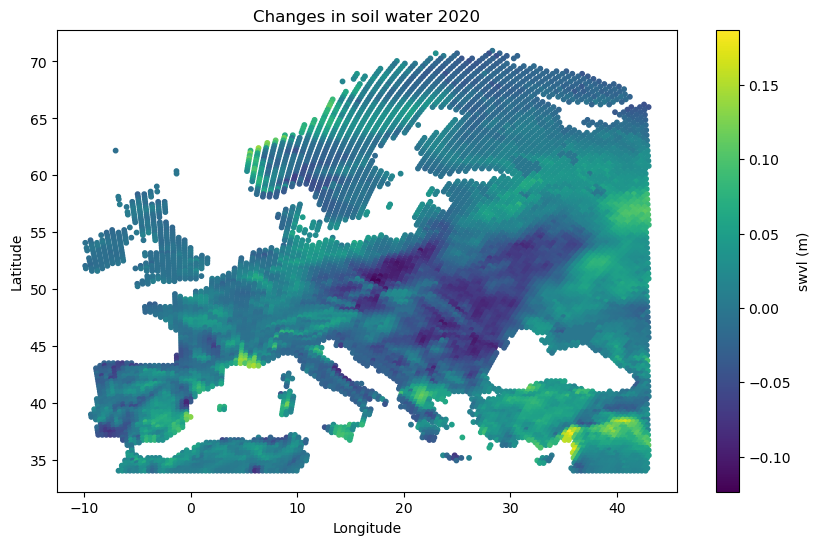

In [127]:
# visualize the output

lat = changes_in_swvl_train['lat'].values
lon = changes_in_swvl_train['lon'].values
values = changes_in_swvl_train.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='swvl (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Changes in soil water 2020')
plt.show()

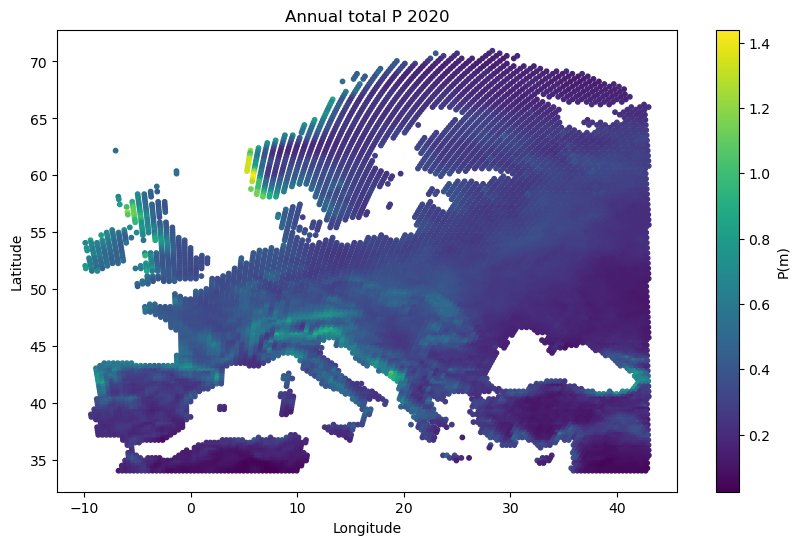

In [126]:
# visualize the output

lat = train_ds_p_acc['lat'].values
lon = train_ds_p_acc['lon'].values
values = train_ds_p_acc.variable.values*10

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='P(m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total P 2020')
plt.show()

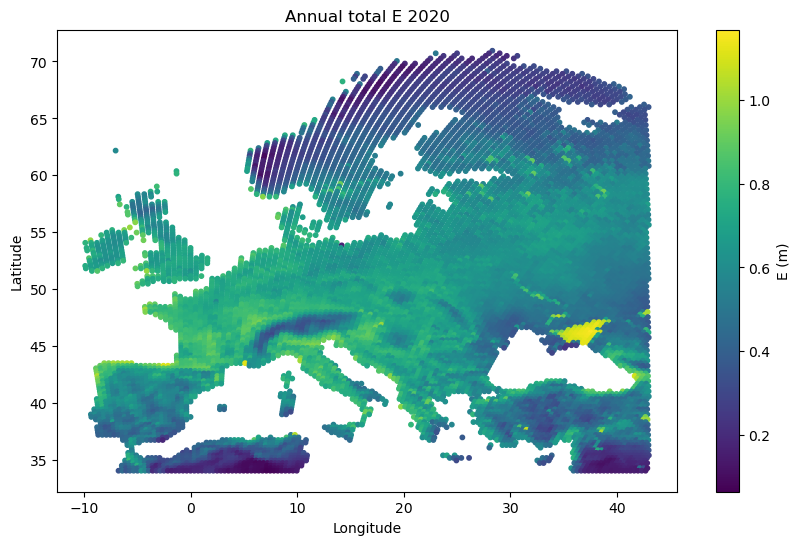

In [125]:
# visualize the output -- Annual E 

lat = train_acc_e['lat'].values
lon = train_acc_e['lon'].values
values = train_acc_e.variable.values*(-1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='E (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total E 2020')
plt.show()

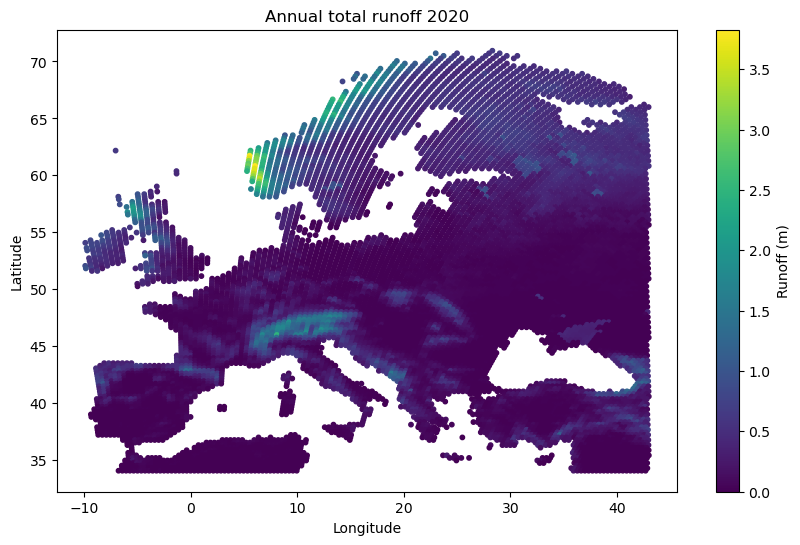

In [128]:
# visualize the output -- Annual SRO+SSRO

lat = train_acc_runoff['lat'].values
lon = train_acc_runoff['lon'].values
values = train_acc_runoff.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='Runoff (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total runoff 2020')
plt.show()

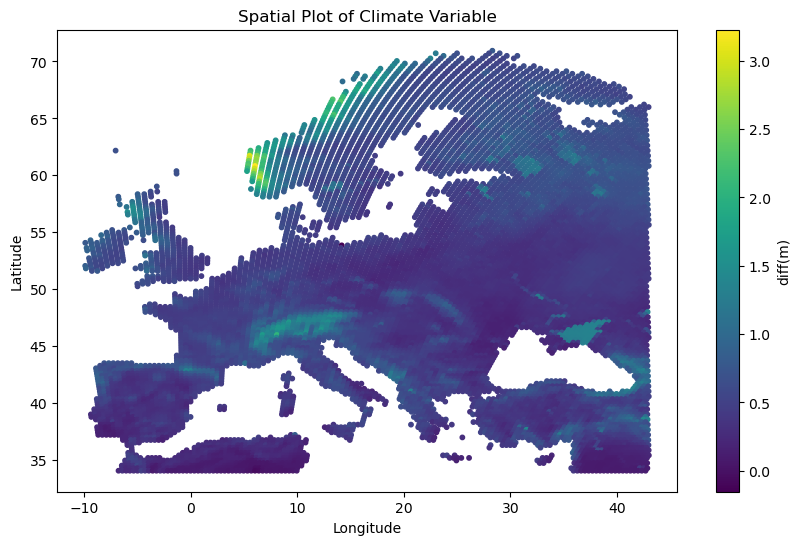

In [120]:
# visualize the output

lat = diff['lat'].values
lon = diff['lon'].values
values = diff.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='diff(m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of Climate Variable')
plt.show()

In [21]:
# For a daily balance
# Yearly Water Balance Evaluation...Test in 2020
# P-ET-R=delta S
# what is the unit? 
# P seems to be much smaller than E?
# Discharge is very large
start_date = '2020-08-01 00:00:00'
end_date = '2020-08-02 00:00:00'
train_ds_e= train_ds.data.sel(variable="e",time=slice(start_date, end_date))
train_ds_sro= train_ds.data.sel(variable="sro",time=slice(start_date, end_date))
train_ds_ssro= train_ds.data.sel(variable="ssro",time=slice(start_date, end_date))
train_ds_swvl1= train_ds.data.sel(variable="swvl1",time=slice(start_date, end_date))
train_ds_swvl2= train_ds.data.sel(variable="swvl2",time=slice(start_date, end_date))
train_ds_swvl3= train_ds.data.sel(variable="swvl3",time=slice(start_date, end_date))

eval_ds_e= eval_ds.data.sel(variable="e",time=slice(start_date, end_date))
eval_ds_sro= eval_ds.data.sel(variable="sro",time=slice(start_date, end_date)) # averaged over the grid area
eval_ds_ssro= eval_ds.data.sel(variable="ssro",time=slice(start_date, end_date))
eval_ds_swvl1= eval_ds.data.sel(variable="swvl1",time=slice(start_date, end_date))
eval_ds_swvl2= eval_ds.data.sel(variable="swvl2",time=slice(start_date, end_date))
eval_ds_swvl3= eval_ds.data.sel(variable="swvl3",time=slice(start_date, end_date))
# convert to day mean?
#changes in soil water: end of year - beginning of year
# total water storage in 3 soil layers
# area (m2) *depth=total volumne of each soil layer --> * swv ratio = total amount of soil water (m3)
train_total_volume_swvl1=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.07*train_ds_swvl1
train_total_volume_swvl2=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.21*train_ds_swvl2
train_total_volume_swvl3=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.72*train_ds_swvl3
train_total_volume_swvl=train_total_volume_swvl1+train_total_volume_swvl2+train_total_volume_swvl3
train_grid_mean_swvl=train_total_volume_swvl/train_ds.clim_data.sel(clim_variable="clim_cell_area") # convert to unit in depth in m

eval_total_volume_swvl1=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.07*eval_ds_swvl1
eval_total_volume_swvl2=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.21*eval_ds_swvl2
eval_total_volume_swvl3=train_ds.clim_data.sel(clim_variable="clim_cell_area")*0.72*eval_ds_swvl3
eval_total_volume_swvl=eval_total_volume_swvl1+eval_total_volume_swvl2+eval_total_volume_swvl3
eval_grid_mean_swvl=eval_total_volume_swvl/train_ds.clim_data.sel(clim_variable="clim_cell_area") # unit in meter

# convert to day mean?
#changes in soil water: end of year - beginning of year
changes_in_swvl_train=train_grid_mean_swvl.isel(time=0)-train_grid_mean_swvl.isel(time=-1)
changes_in_swvl_eval=eval_grid_mean_swvl.isel(time=0)-eval_grid_mean_swvl.isel(time=-1)


In [22]:
# runoff == sur + subsur -- unit in m -- acuumulated
train_ds_runoff=train_ds_sro+train_ds_ssro
eval_ds_runoff=eval_ds_sro+eval_ds_ssro


# time calculation in daily mean? but using which time step? -- using 00:00 everyday as the accumulated daily total amount
train_acc_runoff = train_ds_runoff.sel(time=train_ds_runoff['time'].dt.hour == 0).sum(dim='time')
eval_acc_runoff = eval_ds_runoff.sel(time=eval_ds_runoff['time'].dt.hour == 0).sum(dim='time')

train_acc_e = train_ds_e.sel(time=train_ds_e['time'].dt.hour == 0).sum(dim='time')
eval_acc_e = eval_ds_e.sel(time=eval_ds_e['time'].dt.hour == 0).sum(dim='time')


In [23]:
# p unit transfer

train_ds_p = train_ds.data.sel(variable="met_rainf",time=slice(start_date, end_date))
train_ds_p_acc = train_ds_p.sum(dim='time') # in m
# daily sum?

In [24]:
diff=changes_in_swvl_train-(train_ds_p_acc*10+train_acc_e-train_acc_runoff)

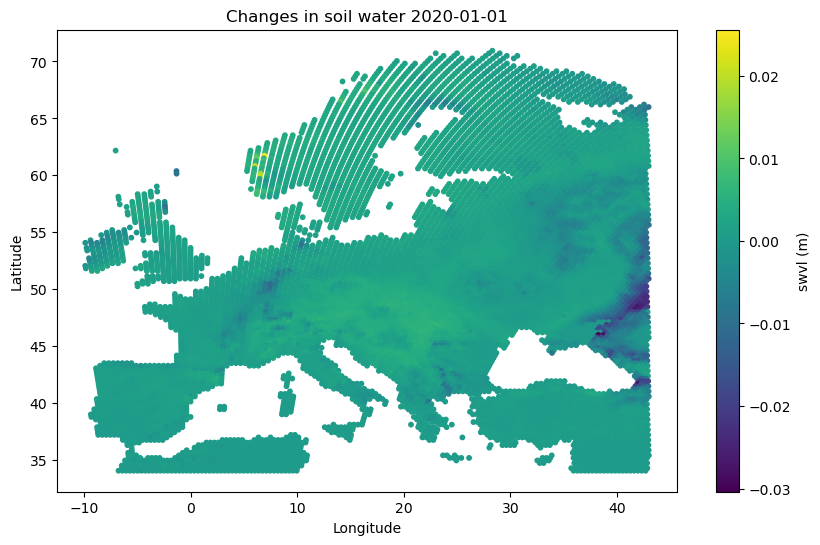

In [25]:
# visualize the output

lat = changes_in_swvl_train['lat'].values
lon = changes_in_swvl_train['lon'].values
values = changes_in_swvl_train.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='swvl (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Changes in soil water 2020-01-01')
plt.show()

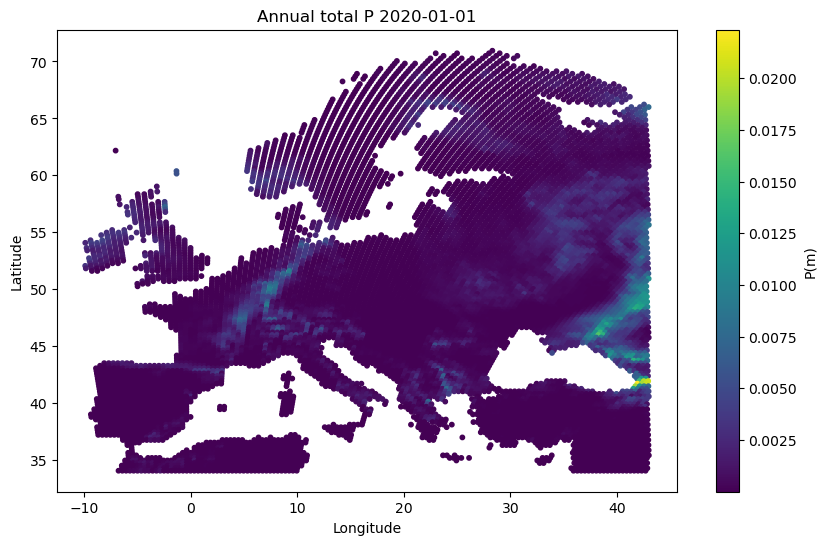

In [26]:
# visualize the output

lat = train_ds_p_acc['lat'].values
lon = train_ds_p_acc['lon'].values
values = train_ds_p_acc.variable.values*10

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='P(m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total P 2020-01-01')
plt.show()

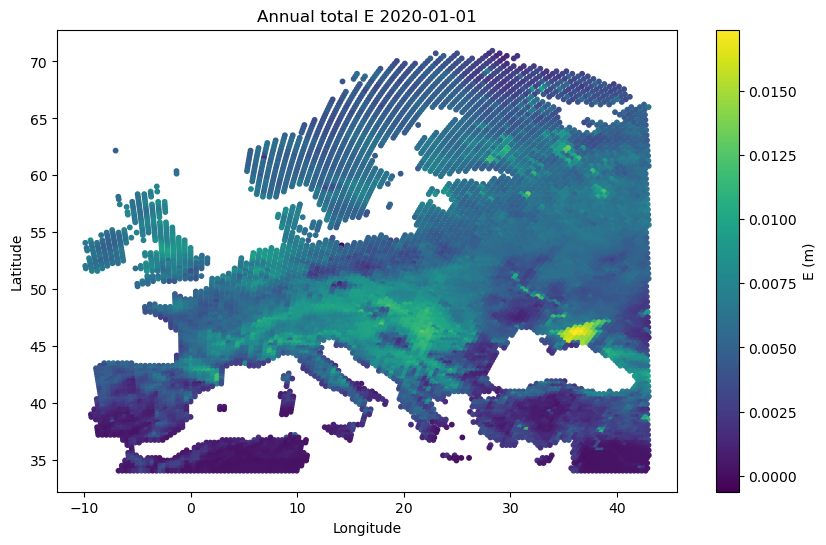

In [27]:
# visualize the output -- Annual E 

lat = train_acc_e['lat'].values
lon = train_acc_e['lon'].values
values = train_acc_e.variable.values*(-1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='E (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total E 2020-01-01')
plt.show()

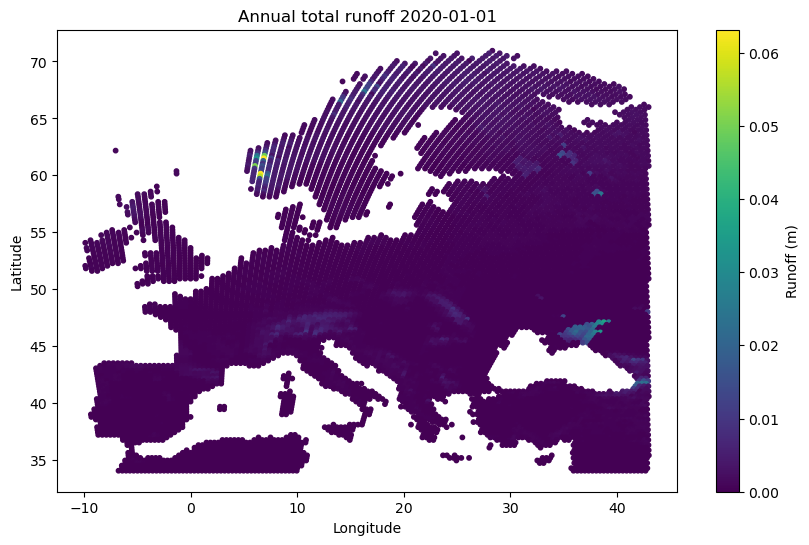

In [28]:
# visualize the output -- Annual SRO+SSRO

lat = train_acc_runoff['lat'].values
lon = train_acc_runoff['lon'].values
values = train_acc_runoff.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='Runoff (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Annual total runoff 2020-01-01')
plt.show()

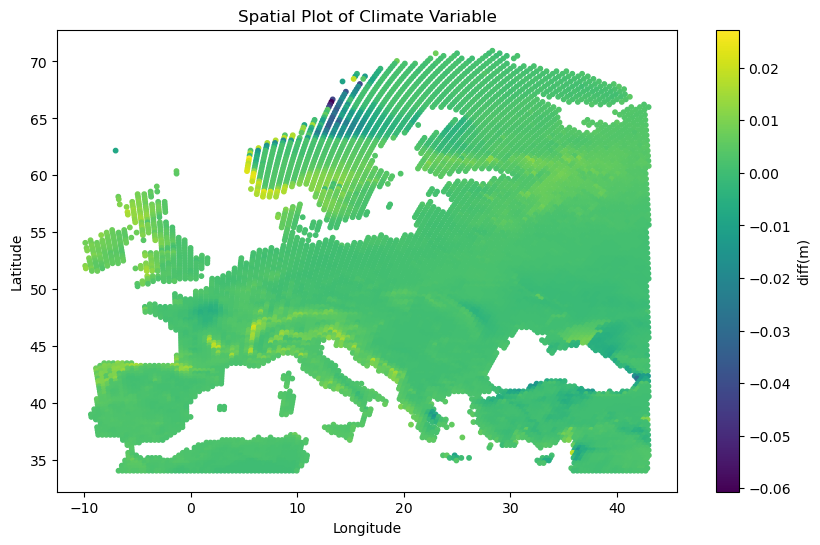

In [20]:
# visualize the output 01-01

lat = diff['lat'].values
lon = diff['lon'].values
values = diff.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='diff(m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of Climate Variable')
plt.show()

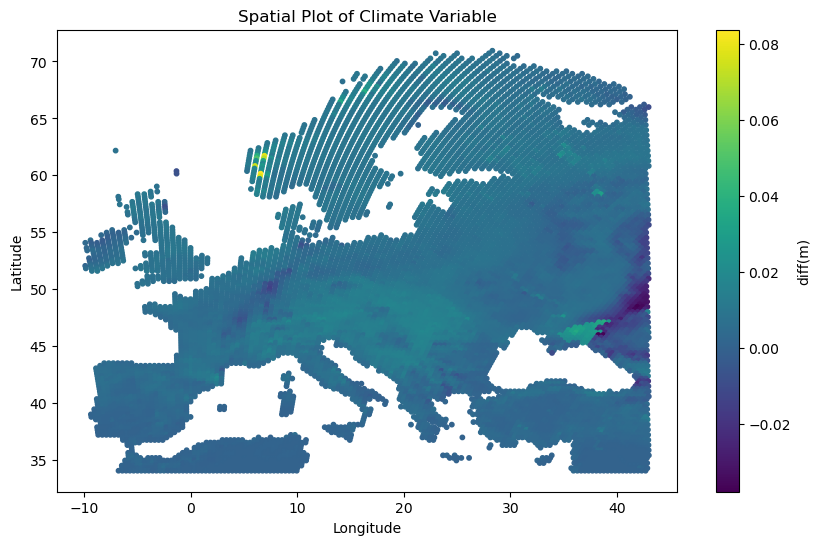

In [29]:
# visualize the output -08-01

lat = diff['lat'].values
lon = diff['lon'].values
values = diff.variable.values

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, c=values, cmap='viridis', s=10)
plt.colorbar(label='diff(m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of Climate Variable')
plt.show()